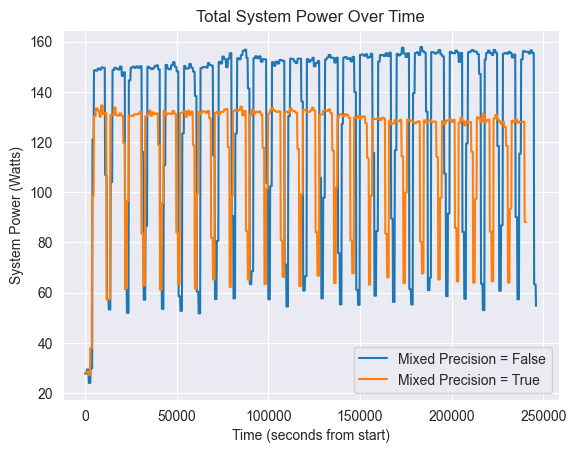

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

false_csvs = glob.glob("mixed_precision_false/**/*.csv", recursive=True)
true_csvs = glob.glob("mixed_precision_true/**/*.csv", recursive=True)

false_csv = false_csvs[0]
true_csv = true_csvs[0]

# Load data
df_false = pd.read_csv(false_csv)
df_true = pd.read_csv(true_csv)

# Normalize time to both start from 0
df_false["Time"] = df_false["Time"] - df_false["Time"].iloc[0]
df_true["Time"] = df_true["Time"] - df_true["Time"].iloc[0]

# Single combined plot
plt.figure()
plt.plot(df_false["Time"], df_false["SYSTEM_POWER (Watts)"], label="Mixed Precision = False")
plt.plot(df_true["Time"], df_true["SYSTEM_POWER (Watts)"], label="Mixed Precision = True")

plt.xlabel("Time (seconds from start)")
plt.ylabel("System Power (Watts)")
plt.title("Total System Power Over Time")
plt.legend()
plt.show()


In [2]:
import numpy as np

def compute_energy(df):
    time = df["Time"] - df["Time"].iloc[0]
    power = df["SYSTEM_POWER (Watts)"]

    energy = np.trapz(power, time)

    return energy

energy_false = compute_energy(df_false)
energy_true = compute_energy(df_true)

print(f"Total Energy (Mixed Precision = False): {energy_false:.2f} Joules")
print(f"Total Energy (Mixed Precision = True):  {energy_true:.2f} Joules")


Total Energy (Mixed Precision = False): 32089129.75 Joules
Total Energy (Mixed Precision = True):  28226890.24 Joules
